# 1. Import library

In [1]:
import os
import time
import math
import copy
import random
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps
import cv2

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    f1_score,
)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split, ConcatDataset, WeightedRandomSampler

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from torchvision.models import ResNet50_Weights
from torchvision.transforms import ToTensor, Normalize

from timm import create_model
from timm.models.swin_transformer import swin_tiny_patch4_window7_224

from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = os.cpu_count()
device, NUM_WORKERS

(device(type='cuda'), 4)

In [3]:
def set_seed(seed=42):
    random.seed(seed)                    # Python
    np.random.seed(seed)                 # NumPy
    torch.manual_seed(seed)              # PyTorch (CPU)
    torch.cuda.manual_seed(seed)         # PyTorch (GPU)
    torch.cuda.manual_seed_all(seed)     # Multi-GPU

#set_seed(77)

In [4]:
# link kaggle dataset
# https://www.kaggle.com/datasets/antruong2477/fer2013-dataset
# https://www.kaggle.com/datasets/antruong2477/affectnet-dataset
# https://www.kaggle.com/datasets/antruong2477/fer2013-and-affectnet-dataset

fer2013_path = Path('/kaggle/input/fer2013-dataset')
affectnet_path = Path('/kaggle/input/affectnet-dataset')
fer2013_and_affectnet_path = Path('/kaggle/input/fer2013-and-affectnet-dataset')

IMG_SIZE = 224
BATCH_SIZE = 32

# 2. Data Processing

In [5]:
def create_dataloader(dataset_path, batch_size=32, num_workers=NUM_WORKERS):
    
    train_dir_path = dataset_path / 'train'
    val_dir_path = dataset_path / 'val'
    test_dir_path = dataset_path / 'test'
    
    # Define augmentation transformations for training data
    train_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])


    # Define transformations for validation and test data (no augmentation)
    val_and_test_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])

    # Load datasets
    train_dataset = datasets.ImageFolder(train_dir_path, transform=train_transform)
    val_dataset = datasets.ImageFolder(val_dir_path, transform=val_and_test_transform)
    test_dataset = datasets.ImageFolder(test_dir_path, transform=val_and_test_transform)

    # Get class distribution
    class_counts = [0] * len(train_dataset.classes)
    for _, label in train_dataset.samples:
        class_counts[label] += 1

    # Calculate weights for each class
    class_weights = 1. / np.array(class_counts)
    sample_weights = [class_weights[label] for _, label in train_dataset.samples]

    # Create WeightedRandomSampler
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    # Create dataloaders with the sampler for the training set
    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, sampler=sampler)
    val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=num_workers)

    class_names = train_dataset.classes

    return train_loader, val_loader, test_loader, class_names

# 3. Models - Swin Transformer with SE Block and ResNet50

## Swin Transformer with SE Block and ResNet50

In [6]:
# SE block
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# Model
class SwinWithSEAndResNetFusion(nn.Module):
    def __init__(self, num_classes=7):
        super(SwinWithSEAndResNetFusion, self).__init__()
        
        # Swin Transformer backbone
        self.swin_backbone = create_model('swin_tiny_patch4_window7_224', pretrained=True, features_only=True)

        # ResNet-50 backbone
        self.resnet_backbone = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.resnet_backbone = nn.Sequential(*list(self.resnet_backbone.children())[:-1])  # Remove FC

        # SE block for Swin output
        self.se_block = SEBlock(768)

        # Split Convolution: giảm chiều đặc trưng Swin từ 768 -> 384 (tuỳ chọn)
        self.split_conv = nn.Conv2d(768, 384, kernel_size=1)

        # Global Average Pooling sau split
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Final classifier
        self.fc = nn.Linear(384 + 2048, num_classes)

    def forward(self, x):
        # --- Swin Transformer branch ---
        swin_feats = self.swin_backbone(x)[-1]              # B, H, W, C
        swin_feats = swin_feats.permute(0, 3, 1, 2)         # B, C, H, W
        swin_feats = self.se_block(swin_feats)              # SE attention
        swin_feats = self.split_conv(swin_feats)            # Split conv để giảm chiều
        swin_feats = self.global_pool(swin_feats)           # Mean pooling
        swin_feats = swin_feats.flatten(1)                  # B, 384

        # --- ResNet-50 branch ---
        resnet_feats = self.resnet_backbone(x)              # B, 2048, 1, 1
        resnet_feats = resnet_feats.flatten(1)              # B, 2048

        # --- Fusion ---
        fused_feats = torch.cat([swin_feats, resnet_feats], dim=1)  # B, 2432
        out = self.fc(fused_feats)                          # Final output
        return out

In [7]:
# SwinT
class SwinTinyClassifier(nn.Module):
    def __init__(self, num_classes=7, pretrained=True):
        super(SwinTinyClassifier, self).__init__()
        # Swin Transformer Tiny backbone
        self.backbone = create_model(
            'swin_tiny_patch4_window7_224',
            pretrained=pretrained,
            num_classes=0,              # Không dùng classifier mặc định
            global_pool='avg'          # Global Average Pooling
        )
        self.classifier = nn.Linear(self.backbone.num_features, num_classes)

    def forward(self, x):
        features = self.backbone(x)         # B, 768
        out = self.classifier(features)     # B, num_classes
        return out


# ResNet-50
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes=7, pretrained=True):
        super(ResNet50Classifier, self).__init__()
        self.backbone = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

# 4. Utility Functions

In [8]:
# Hàm đánh giá mô hình
def evaluate_model(model, data_loader, device, criterion):
    model.eval()
    correct, total = 0, 0
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / total
    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return accuracy, avg_loss, f1
    
# Hàm huấn luyện mô hình
def train_model(model, train_loader, val_loader, epochs, device, dataset_name=None, save_path="/kaggle/working/best_model.pth", patience=10):
    criterion = nn.CrossEntropyLoss()  
    
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    model.to(device)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0  # Early stopping counter

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'val_f1': []
    }

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        scheduler.step()

        train_acc = correct / total
        val_acc, val_loss, val_f1 = evaluate_model(model, val_loader, device, criterion)

        history['train_loss'].append(running_loss / total)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        print(f"\nEpoch {epoch+1}: Train Loss = {running_loss/total:.4f}, Train Acc = {train_acc:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}, Val F1 = {val_f1:.4f}")

        # Early stopping logic
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
            print(f">>> New best model saved! Acc = {best_acc:.4f}")
            epochs_no_improve = 0  # Reset counter
        else:
            epochs_no_improve += 1
            print(f"--- No improvement for {epochs_no_improve} epoch(s)")

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs without improvement.")
            break

    model.load_state_dict(best_model_wts)
    return model, history

# Vẽ biểu đồ lịch sử huấn luyện
def plot_training_history(history, save_path=None):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(18, 5))

    # Accuracy
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_loss'], label='Train Loss', color='orange')
    plt.plot(epochs, history['val_loss'], label='Val Loss', color='red')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss")
    plt.legend()

    # F1 Score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['val_f1'], label='Val F1 Score', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title("Validation F1 Score")
    plt.legend()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path) 
        print(f"Training history plot saved to {save_path}")

    plt.show()

# Vẽ ma trận nhầm lẫn
def plot_confusion_matrix_and_save(model, data_loader, device, class_names, save_path="/kaggle/working/confusion_matrix.png"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

In [9]:
class ExperimentRunner:
    def __init__(self, model, dataset_name, device=device, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        self.model = model
        self.dataset_name = dataset_name
        self.device = device
        self.batch_size = batch_size
        self.num_workers = num_workers

        # Ánh xạ tên dataset sang path tương ứng
        dataset_paths = {
            "fer2013": fer2013_path,
            "affectnet": affectnet_path,
            "fer2013_and_affectnet": fer2013_and_affectnet_path
        }

        if dataset_name not in dataset_paths:
            raise ValueError(f"Dataset '{dataset_name}' không được hỗ trợ.")

        self.dataset_path = dataset_paths[dataset_name]

        self.train_loader, self.val_loader, self.test_loader, self.class_names = create_dataloader(
            self.dataset_path, self.batch_size, self.num_workers
        )

    def train(self, epochs=30):
        print(f"Training on dataset: {self.dataset_name}")
        start_time = time.time()
        self.model, self.history = train_model(
            self.model,
            self.train_loader,
            self.val_loader,
            epochs=epochs,
            device=self.device,
            dataset_name=self.dataset_name
        )
        end_time = time.time()
        print(f"Tổng thời gian huấn luyện: {end_time - start_time:.2f} giây")
        plot_training_history(self.history, save_path=f"/kaggle/working/training_history_{self.dataset_name}.png")

    def evaluate(self):
        print(f"Evaluating on dataset: {self.dataset_name}")
        test_acc, test_loss, test_f1 = evaluate_model(
            self.model,
            self.test_loader,
            device=self.device,
            criterion=nn.CrossEntropyLoss()
        )
        print(f"Accuracy: {test_acc:.4f}, F1-score: {test_f1:.4f}")
        save_path = f"/kaggle/working/confusion_matrix_{self.dataset_name}.png"
        plot_confusion_matrix_and_save(self.model, self.test_loader, self.device, self.class_names, save_path)

    def run(self, epochs=50):
        self.train(epochs)
        self.evaluate()

# 5. Experiment

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s]


Total parameters: 51,411,905
Trainable parameters: 51,411,905
Training on dataset: affectnet


Epoch 1/30: 100%|██████████| 557/557 [03:57<00:00,  2.35it/s]



Epoch 1: Train Loss = 1.1662, Train Acc = 0.5504, Val Loss = 0.9706, Val Acc = 0.6220, Val F1 = 0.6111
>>> New best model saved! Acc = 0.6220


Epoch 2/30: 100%|██████████| 557/557 [03:55<00:00,  2.37it/s]



Epoch 2: Train Loss = 0.7619, Train Acc = 0.7142, Val Loss = 0.8125, Val Acc = 0.6899, Val F1 = 0.6892
>>> New best model saved! Acc = 0.6899


Epoch 3/30: 100%|██████████| 557/557 [03:55<00:00,  2.37it/s]



Epoch 3: Train Loss = 0.6384, Train Acc = 0.7614, Val Loss = 0.8123, Val Acc = 0.7003, Val F1 = 0.6938
>>> New best model saved! Acc = 0.7003


Epoch 4/30: 100%|██████████| 557/557 [03:55<00:00,  2.37it/s]



Epoch 4: Train Loss = 0.5570, Train Acc = 0.7953, Val Loss = 0.7531, Val Acc = 0.7300, Val F1 = 0.7260
>>> New best model saved! Acc = 0.7300


Epoch 5/30: 100%|██████████| 557/557 [03:55<00:00,  2.36it/s]



Epoch 5: Train Loss = 0.4840, Train Acc = 0.8203, Val Loss = 0.7650, Val Acc = 0.7300, Val F1 = 0.7256
--- No improvement for 1 epoch(s)


Epoch 6/30: 100%|██████████| 557/557 [03:55<00:00,  2.36it/s]



Epoch 6: Train Loss = 0.4457, Train Acc = 0.8348, Val Loss = 0.8036, Val Acc = 0.7147, Val F1 = 0.7141
--- No improvement for 2 epoch(s)


Epoch 7/30: 100%|██████████| 557/557 [03:55<00:00,  2.36it/s]



Epoch 7: Train Loss = 0.3982, Train Acc = 0.8527, Val Loss = 0.8391, Val Acc = 0.7223, Val F1 = 0.7237
--- No improvement for 3 epoch(s)


Epoch 8/30: 100%|██████████| 557/557 [03:55<00:00,  2.36it/s]



Epoch 8: Train Loss = 0.3586, Train Acc = 0.8665, Val Loss = 0.7928, Val Acc = 0.7363, Val F1 = 0.7343
>>> New best model saved! Acc = 0.7363


Epoch 9/30: 100%|██████████| 557/557 [03:55<00:00,  2.36it/s]



Epoch 9: Train Loss = 0.3281, Train Acc = 0.8795, Val Loss = 0.7932, Val Acc = 0.7394, Val F1 = 0.7363
>>> New best model saved! Acc = 0.7394


Epoch 10/30: 100%|██████████| 557/557 [03:55<00:00,  2.36it/s]



Epoch 10: Train Loss = 0.2815, Train Acc = 0.8968, Val Loss = 0.8882, Val Acc = 0.7273, Val F1 = 0.7281
--- No improvement for 1 epoch(s)


Epoch 11/30: 100%|██████████| 557/557 [03:55<00:00,  2.37it/s]



Epoch 11: Train Loss = 0.1988, Train Acc = 0.9307, Val Loss = 0.7841, Val Acc = 0.7592, Val F1 = 0.7576
>>> New best model saved! Acc = 0.7592


Epoch 12/30: 100%|██████████| 557/557 [03:55<00:00,  2.36it/s]



Epoch 12: Train Loss = 0.1572, Train Acc = 0.9463, Val Loss = 0.7863, Val Acc = 0.7687, Val F1 = 0.7680
>>> New best model saved! Acc = 0.7687


Epoch 13/30: 100%|██████████| 557/557 [03:55<00:00,  2.37it/s]



Epoch 13: Train Loss = 0.1380, Train Acc = 0.9541, Val Loss = 0.8257, Val Acc = 0.7579, Val F1 = 0.7582
--- No improvement for 1 epoch(s)


Epoch 14/30: 100%|██████████| 557/557 [03:55<00:00,  2.37it/s]



Epoch 14: Train Loss = 0.1202, Train Acc = 0.9588, Val Loss = 0.8074, Val Acc = 0.7601, Val F1 = 0.7604
--- No improvement for 2 epoch(s)


Epoch 15/30: 100%|██████████| 557/557 [03:55<00:00,  2.37it/s]



Epoch 15: Train Loss = 0.1059, Train Acc = 0.9642, Val Loss = 0.8257, Val Acc = 0.7628, Val F1 = 0.7631
--- No improvement for 3 epoch(s)


Epoch 16/30: 100%|██████████| 557/557 [03:55<00:00,  2.36it/s]



Epoch 16: Train Loss = 0.0951, Train Acc = 0.9673, Val Loss = 0.8635, Val Acc = 0.7669, Val F1 = 0.7655
--- No improvement for 4 epoch(s)


Epoch 17/30: 100%|██████████| 557/557 [03:55<00:00,  2.36it/s]



Epoch 17: Train Loss = 0.0910, Train Acc = 0.9690, Val Loss = 0.8758, Val Acc = 0.7646, Val F1 = 0.7644
--- No improvement for 5 epoch(s)


Epoch 18/30: 100%|██████████| 557/557 [03:55<00:00,  2.36it/s]



Epoch 18: Train Loss = 0.0790, Train Acc = 0.9741, Val Loss = 0.8842, Val Acc = 0.7633, Val F1 = 0.7631
--- No improvement for 6 epoch(s)


Epoch 19/30: 100%|██████████| 557/557 [03:55<00:00,  2.36it/s]



Epoch 19: Train Loss = 0.0757, Train Acc = 0.9747, Val Loss = 1.0026, Val Acc = 0.7624, Val F1 = 0.7622
--- No improvement for 7 epoch(s)


Epoch 20/30: 100%|██████████| 557/557 [03:57<00:00,  2.35it/s]



Epoch 20: Train Loss = 0.0720, Train Acc = 0.9759, Val Loss = 0.9600, Val Acc = 0.7588, Val F1 = 0.7584
--- No improvement for 8 epoch(s)


Epoch 21/30: 100%|██████████| 557/557 [03:57<00:00,  2.34it/s]



Epoch 21: Train Loss = 0.0632, Train Acc = 0.9796, Val Loss = 0.9582, Val Acc = 0.7583, Val F1 = 0.7585
--- No improvement for 9 epoch(s)


Epoch 22/30: 100%|██████████| 557/557 [03:57<00:00,  2.34it/s]



Epoch 22: Train Loss = 0.0624, Train Acc = 0.9801, Val Loss = 0.9725, Val Acc = 0.7673, Val F1 = 0.7666
--- No improvement for 10 epoch(s)

Early stopping triggered after 10 epochs without improvement.
Tổng thời gian huấn luyện: 5413.13 giây
Training history plot saved to /kaggle/working/training_history_affectnet.png


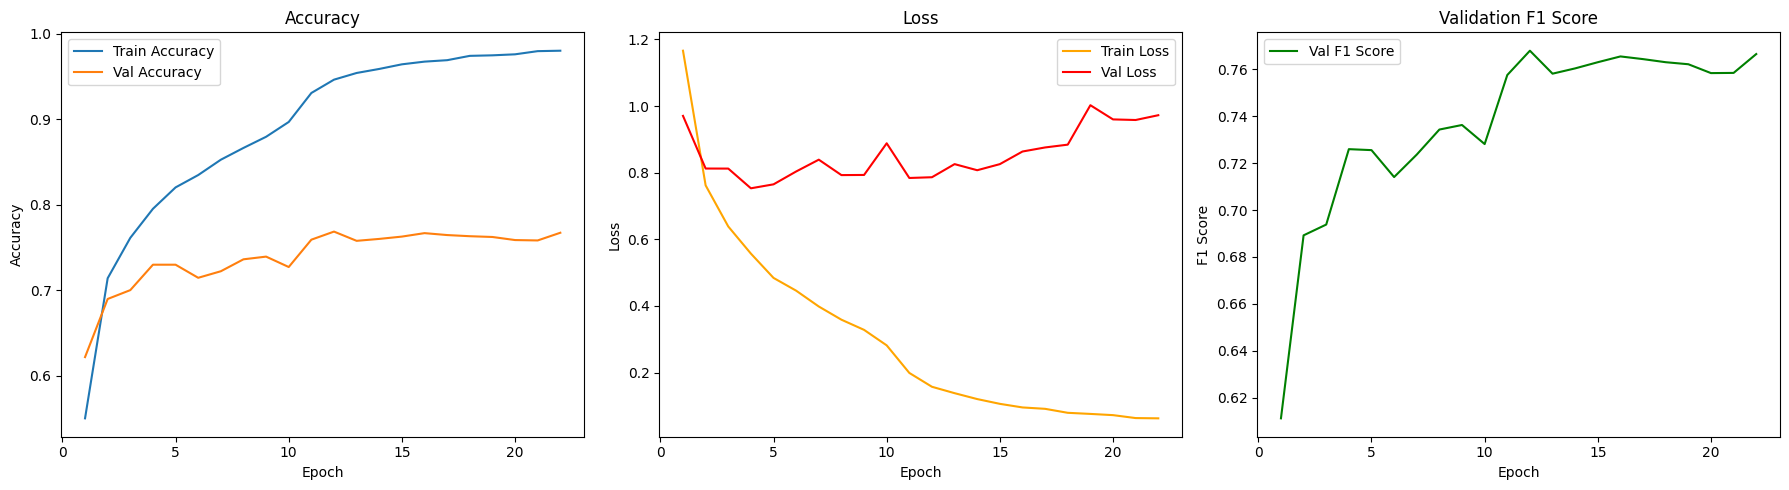

Evaluating on dataset: affectnet
Accuracy: 0.7631, F1-score: 0.7630


In [10]:
# khởi tạo dataset tương ứng: 'fer2013'   'affectnet'   'fer2013_and_affectnet'
dataset_name = 'affectnet'

# khởi tạo model
model = SwinWithSEAndResNetFusion(num_classes=7)  #Swin-SE-ResNet
# model = SwinTinyClassifier(num_classes=7)    #SwinT
# model = ResNet50Classifier(num_classes=7)    #ResNet50
    
# In số lượng tham số
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

epoch = 30

# thực nghiệm
runner = ExperimentRunner(
    model=model,
    dataset_name=dataset_name
)
runner.run(epochs=epoch)